In [1]:
import tensorflow as tf
tf.enable_eager_execution()

C:\Users\prakh\anaconda3\envs\py36\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\prakh\anaconda3\envs\py36\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\prakh\anaconda3\envs\py36\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\prakh\anaconda3\envs\py36\lib\site-packages\tensorflow\python\frame

In [2]:
import argparse
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import scipy.io
import scipy.misc
import numpy as np
import pandas as pd
import PIL
from PIL import ImageFont, ImageDraw, Image
from tensorflow.python.framework.ops import EagerTensor
from tensorflow.keras.models import load_model
from yad2k.models.keras_yolo import yolo_head, space_to_depth_x2, space_to_depth_x2_output_shape
from yolo_utils import read_classes, read_anchors, scale_boxes, preprocess_image, draw_boxes
from yad2k.utils.draw_boxes import get_colors_for_classes
%matplotlib inline

Using TensorFlow backend.


In [3]:
class_names = read_classes("model_data/coco_classes.txt")
anchors = read_anchors("model_data/yolo_anchors.txt")
model_image_size = (608, 608) # Same as yolo_model input layer size

In [4]:
def yolo_filter_boxes(boxes, box_confidence, box_class_probs, threshold = .6):
   
    box_scores = box_confidence*box_class_probs
    box_classes = tf.math.argmax(box_scores, axis=-1)
    box_class_scores = tf.math.reduce_max(box_scores, axis=-1)
    
    filtering_mask = (box_class_scores >= threshold)
    
    scores = tf.boolean_mask(box_class_scores, filtering_mask)
    boxes = tf.boolean_mask(boxes, filtering_mask)
    classes = tf.boolean_mask(box_classes, filtering_mask)
    
    return scores, boxes, classes

In [5]:
def iou(box1, box2):
   
    xi1 = max(box1_x1,box2_x1)
    yi1 = max(box1_y1,box2_y1)
    xi2 = min(box1_x2,box2_x2)
    yi2 = min(box1_y2,box2_y2)
    inter_width = xi2-xi1
    inter_height =  yi2-yi1
    inter_area = max(inter_width,0)*max(inter_height,0)
    
    # Calculate the Union area by using Formula: Union(A,B) = A + B - Inter(A,B)
    box1_area = (box1_x2-box1_x1)*(box1_y2-box1_y1)
    box2_area = (box2_x2-box2_x1)*(box2_y2-box2_y1)
    union_area = box1_area + box2_area - inter_area
    
    # compute the IOU
    iou = inter_area/union_area
    
    return iou

In [6]:
def yolo_non_max_suppression(scores, boxes, classes, max_boxes = 10, iou_threshold = 0.5):
    
    
    max_boxes_tensor = tf.Variable(max_boxes, dtype='int32')     
    nms_indices = tf.image.non_max_suppression(boxes,scores,max_boxes,iou_threshold,name=None)
    
    scores = tf.gather(scores, nms_indices)
    boxes = tf.gather(boxes, nms_indices)
    classes = tf.gather(classes, nms_indices)
    
    return scores, boxes, classes

In [7]:
def yolo_boxes_to_corners(box_xy, box_wh):
    box_mins = box_xy - (box_wh / 2.)
    box_maxes = box_xy + (box_wh / 2.)

    return tf.keras.backend.concatenate([
        box_mins[..., 1:2],  # y_min
        box_mins[..., 0:1],  # x_min
        box_maxes[..., 1:2],  # y_max
        box_maxes[..., 0:1]  # x_max
    ])


In [8]:
# UNQ_C4 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: yolo_eval

def yolo_eval(yolo_outputs, image_shape = (720, 1280), max_boxes=10, score_threshold=.6, iou_threshold=.5):
    
    box_xy, box_wh, box_confidence, box_class_probs = yolo_outputs
    boxes = yolo_boxes_to_corners(box_xy, box_wh)
    scores, boxes, classes = yolo_filter_boxes(boxes, box_confidence, box_class_probs, threshold = score_threshold)
    boxes = scale_boxes(boxes, image_shape)
    scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes, max_boxes = 10, iou_threshold = 0.5)
    
    return scores, boxes, classes

In [9]:
yolo_model = load_model("model_data/yolo.h5")

In [10]:
yolo_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 608, 608, 3) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 608, 608, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 608, 608, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 608, 608, 32) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [17]:
def predict(image_file):
    # Preprocess your image
    image, image_data = preprocess_image("images/" + image_file, model_image_size = (608, 608))
    
    yolo_model_outputs = yolo_model(image_data)
    yolo_outputs = yolo_head(yolo_model_outputs, anchors, len(class_names))
    
    out_scores, out_boxes, out_classes = yolo_eval(yolo_outputs, [image.size[1],  image.size[0]], 10, 0.3, 0.5)

    # Print predictions info
    #print('Found {} boxes for {}'.format(len(out_boxes), "images/" + image_file))
    # Generate colors for drawing bounding boxes.
    colors = get_colors_for_classes(len(class_names))
    # Draw bounding boxes on the image file
    #draw_boxes2(image, out_scores, out_boxes, out_classes, class_names, colors, image_shape)
    draw_boxes(image, out_scores, out_boxes, out_classes, class_names, colors)
    # Save the predicted bounding box on the image
    image.save(os.path.join("out", image_file), quality=100)
    # Display the results in the notebook
    output_image = Image.open(os.path.join("out", image_file))
    imshow(output_image)

    return out_scores, out_boxes, out_classes

traffic light 0.35 (681, 195) (692, 215)
car 0.38 (965, 273) (1023, 292)
car 0.45 (336, 296) (377, 335)
car 0.60 (925, 285) (1045, 374)
bus 0.67 (5, 267) (220, 407)
car 0.68 (705, 279) (786, 351)
car 0.70 (947, 324) (1280, 704)
car 0.75 (159, 303) (346, 440)
car 0.80 (762, 282) (942, 412)
car 0.89 (366, 299) (745, 648)


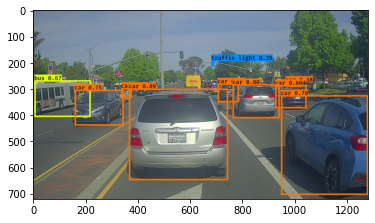

In [18]:
out_scores, out_boxes, out_classes = predict("test.jpg")